In [ ]:
%run ../../lib/basic-import.ipynb
%run ../../lib/plot-functions.ipynb

In [ ]:
import termtables as tt
import os.path

#pip install termtables

┌─────────────────────┬─────────────────────┬─────────────────────┬───────────────────┐
│ original timestamp  │ suggested timestamp │ corrected timestamp │ original distance │
╞═════════════════════╪═════════════════════╪═════════════════════╪═══════════════════╡
│ 2018-06-09 09:21:10 │ 2018-06-09 09:21:02 │ 2018-06-09          │ 33648.29          │
├─────────────────────┼─────────────────────┼─────────────────────┼───────────────────┤
│ 2018-06-09 09:35:35 │ 2018-06-09 09:35:35 │ 2018-06-09          │ 40934.02          │
├─────────────────────┼─────────────────────┼─────────────────────┼───────────────────┤
│ 2018-06-09 11:02:52 │ 2018-06-09 11:02:45 │ 2018-06-09          │ 75978.31          │
└─────────────────────┴─────────────────────┴─────────────────────┴───────────────────┘


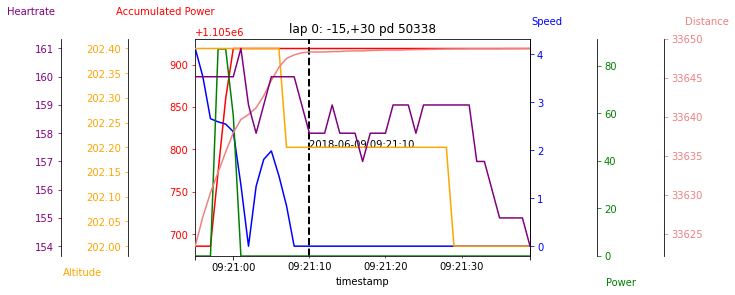

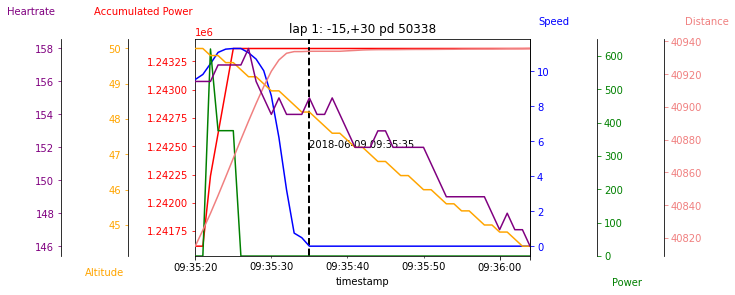

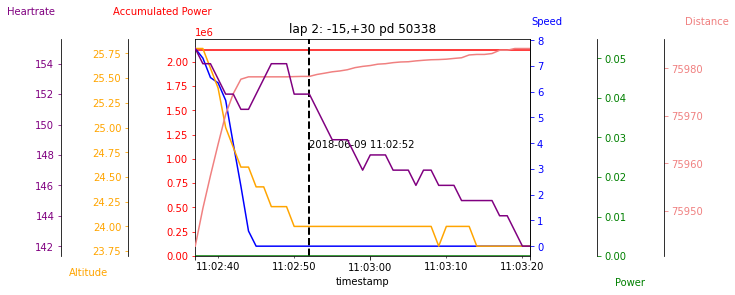

In [12]:
def pd_plot_lap_save_corr_new():
    add_df = pd.concat(all_dfs, axis=1, keys=[a[:-4] for a in participant_files])
    ID = '50338'
    
    #for now, we are only looking at 50338
    add_df_338 = add_df['50338']
    # issue #15
    add_df_338 = add_df_338[add_df_338['timestamp'].notnull()]

    lapRange_df_li = []
    lapTimestamp_li = []
    lapCount = 0
    
    # I think we can improve runtime here
    for i in add_df_338.index:
        if add_df_338.loc[i,'lap'] > lapCount:
            lapTimestamp_li.append(add_df_338.loc[i,'timestamp'])
            lapCount += 1

    # Find +30s, -15 from lap increase, and store all rows
    add_df_338.set_index('timestamp', inplace=True)
    timedelta_30s = pd.Timedelta("00:00:30")
    timedelta_15s = pd.Timedelta("00:00:15")
    for i in range(len(lapTimestamp_li)):
        startRow = add_df_338.index.get_loc(lapTimestamp_li[i]-timedelta_15s)
        endRow = add_df_338.index.get_loc(lapTimestamp_li[i]+timedelta_30s)
        lapRange_df_li.append(add_df_338.iloc[startRow:endRow])

    # Create plot for every stop
    for i in range(len(lapTimestamp_li)):
        fig, ax = plt.subplots()

        trans = ax.get_xaxis_transform()

        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax4 = ax.twinx()
        ax5 = ax.twinx()
        ax6 = ax.twinx()

        rightPosition = 1.00
        leftPosition = -0.20

        rightPosition = ax_modification(ax2,'right', rightPosition)
        rightPosition = ax_modification(ax3,'right', rightPosition)
        leftPosition = ax_modification(ax4,'left', leftPosition)
        rightPosition = ax_modification(ax5,'right', rightPosition)
        leftPosition = ax_modification(ax6,'left', leftPosition)
        
        plot_title = "lap "+str(i)+": -15,+30 pd 50338"

        lapRange_df_li[i]['accumulated_power'].plot(ax=ax, color='red',legend=False, title=plot_title)
        lapRange_df_li[i]['speed'].plot(ax=ax2, color='blue',legend=False)
        lapRange_df_li[i]['power'].plot(ax=ax3, color='green',legend=False)
        lapRange_df_li[i]['altitude'].plot(ax=ax4, color='orange',legend=False)
        lapRange_df_li[i]['distance'].plot(ax=ax5, color='lightcoral',legend=False)
        lapRange_df_li[i]['heart_rate'].plot(ax=ax6, color='purple',legend=False)    
        ax.axvline((lapTimestamp_li[i]), color='black', linestyle='--', lw=2)
        ax.text((lapTimestamp_li[i]),.5,(lapTimestamp_li[i]),transform=trans)

        #dårlige runtime, trenge sikkert ikkje sjekka kver einaste value.
        #bør tenka på ein bedre måte
        check_ylim(ax,lapRange_df_li[i],'accumulated_power')
        check_ylim(ax2,lapRange_df_li[i],'speed')
        check_ylim(ax3,lapRange_df_li[i],'power')
        check_ylim(ax4,lapRange_df_li[i],'altitude')
        check_ylim(ax5,lapRange_df_li[i],'distance')

        ax_style(ax,'Accumulated Power','red')
        ax_style(ax2,'Speed','blue')
        ax_style(ax3,'Power','green')
        ax_style(ax4,'Altitude','orange')
        ax_style(ax5,'Distance','lightcoral')
        ax_style(ax6,'Heartrate','purple')
        
        #bbox_inches makes it possible to see all y axis in image.
        #all the y axis didnt show pdf when incrementing rightposition and leftposition.
        #however think we need to resize it to fit in the pdf.
        fig.savefig("lap"+str(i)+"pd"+str(ID)+".png", format="png", bbox_inches='tight')

    #getting original/suggested/final timestamp and original distance
    timestamp_original = []
    timestamp_suggested = []
    timestamp_final = []
    distance_original = []

    timestamp_original = lapTimestamp_li

    for i in range(len(lapRange_df_li)):
        temp = lapRange_df_li[i][(lapRange_df_li[i]['speed'] == 0) & (lapRange_df_li[i]['power'] == 0)]
        temp.reset_index(inplace=True)
        timestamp_suggested.append(temp.loc[0, 'timestamp'])
        timestamp_final.append(temp.loc[0, 'timestamp'].date())
        distance_original.append(lapRange_df_li[i].loc[lapTimestamp_li[i], 'distance'])

    #allVals is the values over in one array.
    allVals = []
    for i in range(len(timestamp_original)):
        allVals.append([timestamp_original[i], timestamp_suggested[i], timestamp_final[i], distance_original[i]])

    #table which is shown. might change the names.
    # removed lap for now, should add back later
    headerTable = ['original timestamp','suggested timestamp','corrected timestamp','original distance']
    print(tt.to_string(allVals, header=headerTable)) #need help, looks ugly

    #tableDF, used in csv.
    dataTableDF = [headerTable] + allVals
    tableDF = pd.DataFrame(dataTableDF[1:],columns=dataTableDF[0]).set_index('original timestamp')
    tableDF.to_csv('correlation_{}'.format(ID)+'.csv')

    #basicly lager data/ID folders hvis ikke eksisterer. Hvis data/id/csv fil eksisterer, slett og flytt den nye der. Samme med bilder. Ser sykt ut då hahah.
    if not os.path.exists('../data/{}'.format(ID)):
        os.makedirs('../data/{}'.format(ID))
    if os.path.exists('../data/{}/correlation_{}.csv'.format(ID,ID)):
        os.remove('../data/{}/correlation_{}.csv'.format(ID,ID))
    os.rename('./correlation_{}.csv'.format(ID), '../data/{}/correlation_{}.csv'.format(ID,ID))
    for i in range(len(lapTimestamp_li)):
        if os.path.exists('../data/{}/lap{}pd{}.png'.format(ID,i,ID)):
            os.remove('../data/{}/lap{}pd{}.png'.format(ID,i,ID))
        os.rename('./lap{}pd{}.png'.format(i,ID), '../data/{}/lap{}pd{}.png'.format(ID,i,ID))

pd_plot_lap_save_corr_new()

In [ ]:
def pd_plot_lap_save_corr():
    add_df = pd.concat(all_dfs, axis=1, keys=[a[:-4] for a in participant_files])
    ID = '50338'
    rightPosition = 1.00
    leftPosition = -0.10

    fig, ax = plt.subplots()
    fig.subplots_adjust(right=2)

    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()
    ax5 = ax.twinx()
    ax6 = ax.twinx()

    rightPosition = ax_modification(ax2,'right', rightPosition)
    rightPosition = ax_modification(ax3,'right', rightPosition)
    leftPosition = ax_modification(ax4,'left', leftPosition)
    rightPosition = ax_modification(ax5,'right', rightPosition)
    leftPosition = ax_modification(ax6,'left', leftPosition)

    lapDates = add_df[ID].index[add_df[ID]['lap'].diff()==1]
    #create new pd lap_df. Contains only +30, -15 sec laps, 1 ekstra for nans.
    #lap_df, gir en ny dataframe. Denne inneholder de tre lap_dfs dataframe.
    lap_dfs = get_lapdf(add_df, ID, 15, 32, lapDates)
    lap_df = pd.concat(lap_dfs)
    lap_df.index = map(lambda x: str(x)[-8:], lap_df.index)

    lap_df['accumulated_power'].plot(ax=ax, color='red',legend=False, title="all laps -15,+30 pd 50338")
    lap_df['speed'].plot(ax=ax2, color='blue',legend=False)
    lap_df['power'].plot(ax=ax3, color='green',legend=False)
    lap_df['altitude'].plot(ax=ax4, color='orange',legend=False)
    lap_df['distance'].plot(ax=ax5, color='lightcoral',legend=False)
    lap_df['heart_rate'].plot(ax=ax6, color='purple',legend=False)

    ax_style(ax,'Accumulated Power','red')
    ax_style(ax2,'Speed','blue')
    ax_style(ax3,'Power','green')
    ax_style(ax4,'Altitude','orange')
    ax_style(ax5,'Distance','lightcoral')
    ax_style(ax6,'Heartrate','purple')

    #getting correlation values, now values and changeable values.
    nowVals = get_now_val(lapDates, ID, add_df)
    corrVals = get_corr_val(lap_dfs)
    changVals = [date.date() for date in lapDates]

    #allVals is the values over in one array.
    allVals = []
    for i in range(len(corrVals)):
        allVals.append([changVals[i]] + [corrVals[i]] + nowVals[i])

    #table which is shown. might change the names.
    headerTable = ['timestamp correlation changeable','timestamp correlation suggestion','timestamp now','lap','distance']
    print(tt.to_string(allVals, header=headerTable))

    #tableDF, used in csv.
    dataTableDF = [headerTable] + allVals
    tableDF = pd.DataFrame(dataTableDF[1:],columns=dataTableDF[0]).set_index('timestamp correlation changeable')
    tableDF.to_csv('correlation_{}'.format(ID)+'.csv')


pd_plot_lap_save_corr()

In [ ]:
def pd_plot_corr():
    add_df = pd.concat(all_dfs, axis=1, keys=[a[:-4] for a in participant_files])
    ID = '50338'
    rightPosition = 1.00
    leftPosition = -0.10

    fig, ax = plt.subplots()
    fig.subplots_adjust(right=2)

    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()
    ax5 = ax.twinx()
    ax6 = ax.twinx()

    rightPosition = ax_modification(ax2,'right', rightPosition)
    rightPosition = ax_modification(ax3,'right', rightPosition)
    leftPosition = ax_modification(ax4,'left', leftPosition)
    rightPosition = ax_modification(ax5,'right', rightPosition)
    leftPosition = ax_modification(ax6,'left', leftPosition)

    lapDates = add_df[ID].index[add_df[ID]['lap'].diff()==1]

    corrDF = pd.read_csv('correlation_{}'.format(ID)).set_index("timestamp correlation changeable")
    corrTS = get_corrTS(corrDF)

    lap_dfs = get_lapdf(add_df, ID, 15, 32, corrTS)
    lap_df = pd.concat(lap_dfs)
    lap_df.index = map(lambda x: str(x)[-8:], lap_df.index)


    lap_df['accumulated_power'].plot(ax=ax, color='red',legend=False, title="corr laps -15,+30 pd 50338")
    lap_df['speed'].plot(ax=ax2, color='blue',legend=False)
    lap_df['power'].plot(ax=ax3, color='green',legend=False)
    lap_df['altitude'].plot(ax=ax4, color='orange',legend=False)
    lap_df['distance'].plot(ax=ax5, color='lightcoral',legend=False)
    lap_df['heart_rate'].plot(ax=ax6, color='purple',legend=False)

    ax_style(ax,'Accumulated Power','red')
    ax_style(ax2,'Speed','blue')
    ax_style(ax3,'Power','green')
    ax_style(ax4,'Altitude','orange')
    ax_style(ax5,'Distance','lightcoral')
    ax_style(ax6,'Heartrate','purple')

pd_plot_corr()